> ### EEE4423: Deep Learning Lab

# LAB #7: High-level Vision - Single Shot Object Detection (YOLO)

<h4><div style="text-align: right"> Due date: APRIL 20, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 2 PM in the form of [ID_Name_Lab07.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">2018142192 최순규</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-04-18 13:58:37.914801


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.autograd import Variable

import torchvision.datasets as dsets

import numpy as np
import cv2

import os
import struct
import copy
import random

import time
import datetime

import math

from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils import data
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

### 1. What is the Object Detection?

>
> <img src="https://drive.google.com/uc?export=view&id=1pOo5As8Qo8bQOQjOkkpRwjVKcKNB4gSE" alt="no_image" style="width: 800px;"/>
>
> - The difference between $\bf{classification}$ (left) and $\bf{detection}$ (right) is simple
>
> - In image classification, the entire image is classified with a single label
>
> - In object detection, the network localizes (potentially multiple) objects within the image
>
> - Therefore, given the image, the obejct detection networks ouput a list of bounding box, class label, and **probability/confidence score**
>

### 2. About YOLO (Main idea)

>
> <img src="https://drive.google.com/uc?export=view&id=1K7tvcGXdRHBc_t5p-m3uyRrCBFbJ9ze5" alt="no_image" style="width: 800px;"/>
>
> - YOLO is an algorithm for object detection
>
> - They reframe object detection as a $\bf{single\ regression\ problem}$, straight from image pixels to bounding box coordinates and class probabilities
>
> - Using YOLO, you only look once (YOLO) at an image to predict what objects are present and where they are
>
> - The advantage of YOLO is the speed, which is extremely fast, since the authors reframe detection as a regression problem not using a complex pipeline
>
> - What are differences between YOLO and previous detectors?? Refer to https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e

### 3. Building a YOLO with PyTorch

> ### YOLO model: 
> - 22Convolutional Layers
>
>     - Note that, first and 20th conv layers have stride 2 for halving output size
>
> - 4 Max Pooling Layers
>
> - 2 Fully Connected Layers
>
> - Leaky ReLu Activation for all layers except for the last layer

### 4. Implementing YOLO
>
> - The input image is divided into an S $\times$ S grid of cells
> 
> - Each grid cell predicts B (=2) bounding boxes as well as C (=20) class probabilities
>
> - Each bounding box consists of 5 predictions: x, y, w, h, and confidence 
> 
> - The (x,y) coordinates represent the center of the box relative to the bounds of the grid cell
> 
> - The width and height are predicted relative to the whole image
>
> - If no object exists in that cell, the confidence score is zero.
>
> - If the cell contains objects, the confidence score is equal to the intersection over union (IOU) between the predicted box and the ground truth (**This is important for building the loss function**)
>
> - Thus, the output vector is a S $\times$ S $\times$ (B $\times$ 5 + C) (= 7 $\times$ 7 $\times$ 30)
> 
> <img src="https://drive.google.com/uc?export=view&id=1LdKtTyYjGKKWmu-4nTYBEMI7n4Sk0aeB" alt="no_image" style="width: 600px;"/>
>
> - You must study *generate_target* function in detail, it contains the process of generating output vectors
>
> Step 1: Load the dataset
>
> Step 2: Build the YOLO network ($\bf{4 points}$)
>> 
>>  <img src="https://drive.google.com/uc?export=view&id=1c4yOWTZacei0_pFoI47wfxVEhM5Tms8X" alt="no_image" style="width: 800px;"/>
>> 
>> - Following the YOLO model, you build yolo network
>> - **Note that our model is different from network of original paper. Please follow above figure.**
>> - You must fill out the blank in **self.pre_train_net** and **self.post_net** blocks
>> - All layers use the following Leaky ReLU (0.01 slope for negative part - Note that it is different from the paper)
>>
>>
>> #### **self.pre_train_net**
>> 
>>
>>
>>| Name       | Filters              | Output Dimension | Padding |
>>|------------|----------------------|------------------| ------- |    
>>| Conv 1     | 7 x 7 x 64, stride=2 | 224 x 224 x 64   | 3       |
>>| LeakyReLU  | negative_slop=0.01   | 224 x 224 x 64   |         |
>>| Max Pool 1 | 2 x 2, stride=2      | 112 x 112 x 64   |         | 
>>|
>>| Conv 2     | 3 x 3 x 192          | 112 x 112 x 192  | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 112 x 112 x 192  |         |
>>| Max Pool 2 | 2 x 2, stride=2      | 56 x 56 x 192    |         | 
>>|
>>| Conv 3     | 1 x 1 x 128          | 56 x 56 x 128    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 56 x 56 x 128    |         |
>>| Conv 4     | 3 x 3 x 256          | 56 x 56 x 256    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 56 x 56 x 256    |         |
>>| Conv 5     | 1 x 1 x 256          | 56 x 56 x 256    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 56 x 56 x 256    |         |
>>| Conv 6     | 3 x 3 x 512          | 56 x 56 x 512    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 56 x 56 x 512    |         |
>>| Max Pool 3 | 2 x 2, stride=2      | 28 x 28 x 512    |         | 
>>|
>>| Conv 7     | 1 x 1 x 256          | 28 x 28 x 256    | 0       | 
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 256    |         |
>>| Conv 8     | 3 x 3 x 512          | 28 x 28 x 512    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 512    |         |
>>| Conv 9     | 1 x 1 x 256          | 28 x 28 x 256    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 256    |         |
>>| Conv 10    | 3 x 3 x 512          | 28 x 28 x 512    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 512    |         |
>>| Conv 11    | 1 x 1 x 256          | 28 x 28 x 256    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 256    |         |
>>| Conv 12    | 3 x 3 x 512          | 28 x 28 x 512    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 512    |         |
>>| Conv 13    | 1 x 1 x 256          | 28 x 28 x 256    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 256    |         |
>>| Conv 14    | 3 x 3 x 512          | 28 x 28 x 512    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 512    |         |
>>| Conv 15    | 1 x 1 x 512          | 28 x 28 x 512    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 512    |         |
>>| Conv 16    | 3 x 3 x 1024         | 28 x 28 x 1024   | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 1024   |         |
>>| Max Pool 4 | 2 x 2, stride=2      | 14 x 14 x 1024   |         | 
>>|
>>| Conv 17    | 1 x 1 x 512          | 14 x 14 x 512    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 14 x 14 x 512    |         |
>>| Conv 18    | 3 x 3 x 1024         | 14 x 14 x 1024   | 1       | 
>>| LeakyReLU  | negative_slop=0.01   | 14 x 14 x 1024   |         |
>>
>> #### **self.post_net**
>>
>>| Name      | Filters                | Output Dimension | Padding | 
>>|-----------|------------------------|------------------| ------- | 
>>| Conv 19   | 3 x 3 x 1024           | 14 x 14 x 1024   | 1       | 
>>| LeakyReLU | negative_slop=0.01     | 14 x 14 x 1024   |         |
>>| Conv 20   | 3 x 3 x 1024, stride=2 | 7 x 7 x 1024     | 1       | 
>>| LeakyReLU | negative_slop=0.01     | 7 x 7 x 1024     |         |
>>| Conv 21   | 3 x 3 x 1024           | 7 x 7 x 1024     | 1       |
>>| LeakyReLU | negative_slop=0.01     | 7 x 7 x 1024     |         |
>>| Conv 22   | 3 x 3 x 1024           | 7 x 7 x 1024     | 1       |
>>| LeakyReLU | negative_slop=0.01     | 7 x 7 x 1024     |         |
>>
> Step 3: Loss function ($\bf{6 points}$)
>
>> - Fill out the code considering the loss function in YOLO
>> - The loss function is composed like below
>> <img src="https://drive.google.com/uc?export=view&id=1QcAP__J50M379GAul7SlhAzzU551tuDj" alt="no_image" style="width: 600px;"/>
>>
>> - $\mathbb{1}_{obj}$ is defined as follows:
>>    - 1, if an object is present in grid cell $i$ and the $j$th bounding box predictor
>>    - 0, otherwise
>>
>> - YOLO predicts multiple bounding boxes per grid cell (in our case, 2 bounding boxes are predicted)
>> - In train stage, YOLO requires one bounding box predictor to be responsible for each object 
>> - The code assigns one predictor to be "responsible" for predicting an object where the predictor has the highest IOU with the ground truth
>> - The loss function is divided into the three sub-sections
>>    1. Classification ( $\bf{6}$ classes ) ($\bf{2 points}$)
>>       <img src="https://drive.google.com/uc?export=view&id=13mnxg_GNtbWnYLpe1P6zopf693zTYe22" alt="no_image" style="width: 300px;"/>
>>
>>       - Similar to sum-squared error for classification except for $\mathbb{1}_{obj}$ term
>>
>>       - Note that, we do not penalize classification error when no object is present on the cell (by $\mathbb{1}_{obj}$ term)
>>
>>    2. No object appears in cell ($\bf{2 points}$)
>>       <img src="https://drive.google.com/uc?export=view&id=1R74HzbRLoX2K5zun8XSLAnRQlKq25XFV" alt="no_image" style="width: 300px;"/>
>>
>>       - Compute the loss associated with the confidence score for each bounding box predictor
>>
>>       - $\mathbb{1}_{noobj}$ is equal to one when there is no object in the cell, and 0 other wise
>>    3. Bounding box coordinates (x,y,h,w) regression (4 scalars), and Object confidence ($\bf{2 points}$)
>>       <img src="https://drive.google.com/uc?export=view&id=1lXs5lHUiXGxgMRNCiViY6SyRDL52gQsy" alt="no_image" style="width: 600px;"/>
>>
>>       - Compute the loss realted to the predicted bounding box position $(x,y)$ and width/height $(w,h)$
>>
>>       - Note that width/height are adapted square root before computing the loss
>>
>>       - In order to solve the problem that small deviations in large boxes matter less than in small boxes
>>
>>       - Compute the loss associated with the confidence score for the cell which is responsible for the object
>>
>> - Following the paper, $\lambda_{coord} = 5$ and $\lambda_{noobj} = 0.5$
>>
> Step 4: Train Model ($\bf{2 points}$)
>>
>> - Based on the above code, you build train code on your own
>> - The necessary things are provided (e.g., *optimizer* and *num_epoch*)
>> - Note that, we offer the pre-trained model since it requires large training time.
>> - If you construct your code correctly, the performance of mAP will be over 0.69 mAP in 10 epochs (about 15 minitues.)
>>
> Step 5: Inference
>>
>> - We offer the test code in below
>> - You can check the qualitative results using the visualization code
>> - The quantitative results will be evaluated by using the mAP code
>> - If the performance of mAP is significantly decreased from the pre-trained model (0.685 mAP), your code will be wrong
>>
>> Step 5-1: Inference (Visualization)
>> 
>> Step 5-2: Inference (mAP) 

### Step 1. Load the dataset

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

class YoloDataset(data.Dataset):
    def __init__(self, root, list_file, train, transform=None):
        self.image_size = 448
        self.root = root
        self.train = train
        self.transform = transform
        self.fnames = []
        self.boxes = []
        self.labels = []
        self.color_jitter = Compose([transforms.ColorJitter(brightness=0.1,contrast=0.1, saturation=0.1, hue=0.1),
                                                 transforms.ToTensor()])
        self.plain = Compose([transforms.ToTensor()])
        self.resize = Compose([transforms.ToPILImage(),
                              transforms.Resize((self.image_size, self.image_size)),
                              transforms.ToTensor()])
        
        with open(list_file) as f:
            lines = f.readlines()
            
        for line in lines:
            splited = line.strip().split()
            self.fnames.append(splited[0])
            num_boxes = (len(splited) - 1) // 5
            box = []
            label = []
            for i in range(num_boxes):
                x_min = float(splited[1+5*i])
                y_min = float(splited[2+5*i])
                x_max = float(splited[3+5*i])
                y_max = float(splited[4+5*i])
                c = splited[5+5*i]
                box.append([x_min, y_min, x_max, y_max])
                label.append(int(c)+1)
            self.boxes.append(torch.Tensor(box))
            self.labels.append(torch.LongTensor(label))
        self.num_samples = len(self.boxes)
        
    def img_pre_process(self, img, boxes, labels):
        
        if random.random() < 0.5:
            im_lr = np.fliplr(img).copy()
            height, width, c = img.shape
            x_min = width - boxes[:, 2]
            x_max = width - boxes[:, 0]
            boxes[:,0] = x_min
            boxes[:,2] = x_max
            img = im_lr
        
        ## Converting the image and box information scaling
        if random.random() < 0.5:
            scale = random.uniform(0.8, 1.2)
            height, width, c = img.shape
            img = cv2.resize(img, (int(width * scale), height))
            boxes = boxes * torch.FloatTensor([[scale, 1, scale, 1]]).expand_as(boxes)
            
        ## Image translation
        if random.random() < 0.5:
            center = (boxes[:,2:] + boxes[:,:2]) / 2
            height, width, c = img.shape
            shifted_img = np.zeros((height, width, c), dtype=img.dtype)
            
            w_range = int(random.uniform(-width*0.2, width*0.2))
            h_range = int(random.uniform(-height*0.2, height*0.2))
            
            if w_range<0 and h_range<0:
                shifted_img[:height+h_range,:width+w_range,:] = img[-h_range:,-w_range:,:]
                
            elif w_range<0 and h_range>=0:
                shifted_img[h_range:,:width+w_range,:] = img[:height-h_range,-w_range:,:]
            
            elif w_range>=0 and h_range>=0:
                shifted_img[h_range:,w_range:,:] = img[:height-h_range,:width-w_range,:]
                
            elif w_range>=0 and h_range<0:
                shifted_img[:height+h_range,w_range:,:] = img[-h_range:,:width-w_range,:]
                
            wh_range = torch.FloatTensor([[w_range, h_range]]).expand_as(center)
            center = center + wh_range
            
            mask1 = (center[:,0] > 0) & (center[:,0] < width)
            mask2 = (center[:,1] > 0) & (center[:,1] < height)
            mask = (mask1 & mask2).view(-1,1).bool()
            
            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            
            if len(boxes_in) != 0:
                box_shift = torch.FloatTensor([[w_range, h_range, w_range, h_range]]).expand_as(boxes_in)
                boxes_in = boxes_in + box_shift
                
                labels_in = labels[mask.view(-1)]
                labels = labels_in
                img = shifted_img
                boxes = boxes_in
        
        ## Image cropping
        if random.random() < 0.5:
            center = (boxes[:,2:] + boxes[:,:2]) / 2
            height, width, c = img.shape
            h = int(random.uniform(0.6*height,height))
            w = int(random.uniform(0.6*width,width))
            x = int(random.uniform(0,width-w))
            y = int(random.uniform(0,height-h))
            
            center = center - torch.FloatTensor([[x, y]]).expand_as(center)
            mask1 = (center[:,0]>0) & (center[:,0]<w)
            mask2 = (center[:,1]>0) & (center[:,1]<h)
            mask = (mask1 & mask2).view(-1, 1).bool()
            
            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            
            if (len(boxes_in)!=0):
                box_shift = torch.FloatTensor([x,y,x,y]).expand_as(boxes_in)

                boxes_in = boxes_in - box_shift
                boxes_in[:,0]=boxes_in[:,0].clamp_(min=0,max=w)
                boxes_in[:,2]=boxes_in[:,2].clamp_(min=0,max=w)
                boxes_in[:,1]=boxes_in[:,1].clamp_(min=0,max=h)
                boxes_in[:,3]=boxes_in[:,3].clamp_(min=0,max=h)

                labels = labels[mask.view(-1)]
                img_cropped = img[y:y+h, x:x+w, :]
                boxes = boxes_in
                img = img_cropped
        
        return img, boxes, labels

    def generate_target(self, img, boxes, labels):
        grid_size = 7
        h,w,_ = img.shape
        boxes /= torch.Tensor([w,h,w,h]).expand_as(boxes) # Converting the box size 0 ~ 1
        target = torch.zeros((grid_size, grid_size, 30)) 
        cell_size = 1./grid_size 

        wh = boxes[:,2:] - boxes[:,:2]
        cxcy = (boxes[:,2:] + boxes[:,:2]) / 2
        
        for i in range(cxcy.size()[0]):
            cxcy_sample = cxcy[i] # center pixel 
            ij = (cxcy_sample/cell_size).ceil()-1 
            target[int(ij[1]),int(ij[0]),4] = 1
            target[int(ij[1]),int(ij[0]),9] = 1
            target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1
            
            xy = ij*cell_size 
            delta_xy = (cxcy_sample -xy)/cell_size # Converting delta_xy to the size 
                                                   # relative to the bounds of the grid cell
            target[int(ij[1]),int(ij[0]),2:4] = wh[i]
            target[int(ij[1]),int(ij[0]),:2] = delta_xy
            target[int(ij[1]),int(ij[0]),7:9] = wh[i]
            target[int(ij[1]),int(ij[0]),5:7] = delta_xy
            
        return target
    
    def RandomBrightness(self,bgr):
        if random.random() < 0.5:
            hsv = cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            v = v*adjust
            v = np.clip(v, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        return bgr
    def RandomSaturation(self,bgr):
        if random.random() < 0.5:
            hsv = cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            s = s*adjust
            s = np.clip(s, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        return bgr
    def RandomHue(self,bgr):
        if random.random() < 0.5:
            hsv = cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            h = h*adjust
            h = np.clip(h, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        return bgr

    def randomBlur(self,bgr):
        if random.random()<0.5:
            bgr = cv2.blur(bgr,(5,5))
        return bgr
        
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.imread(os.path.join(self.root+fname))
        boxes = self.boxes[idx].clone()
        labels = self.labels[idx].clone()

        if self.train:
            img = self.randomBlur(img)
            img = self.RandomBrightness(img)
            img = self.RandomHue(img)
            img = self.RandomSaturation(img)
            img, boxes, labels = self.img_pre_process(img, boxes, labels)
            
        target = self.generate_target(img, boxes, labels) # 7x7x30
        
        # Image processing
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = self.plain(img)
        img = self.resize(img)
        img = 2 * img - 1
        
        return img, target
    
    def __len__(self):
        return self.num_samples
            

### Step 2. Build the YOLO network (2 points)

> You should build model using nn.Sequential. Otherwise, problem arises when loading pretrained weights.

In [4]:
class YOLO(nn.Module):
    def __init__(self):
        super(YOLO, self).__init__()
        
        self.pre_train_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(), #The default slop value of LeakyReLU 0.01
            nn.MaxPool2d(kernel_size=2, stride=2), #MaxPool1

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.LeakyReLU(), #0.01
            nn.MaxPool2d(kernel_size=2, stride=2), #MaxPool2

            nn.Conv2d(192, 128, kernel_size=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #MaxPool3
            
            nn.Conv2d(512, 256, kernel_size=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding = 1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding = 1),
            nn.LeakyReLU(),
            
            nn.Conv2d(512, 256, kernel_size=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding = 1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding = 1),
            nn.LeakyReLU(),
            
            nn.Conv2d(512, 512, kernel_size=1),
            nn.LeakyReLU(),
            
            nn.Conv2d(512, 1024, kernel_size=3, padding = 1),
            nn.LeakyReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2), #MaxPool4
            
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.LeakyReLU(),
            
            nn.Conv2d(512, 1024, kernel_size=3, padding = 1),
            nn.LeakyReLU()
            #pre_train_net end
        )
        
        self.post_net = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, padding = 1),
            nn.LeakyReLU(),
            
            nn.Conv2d(1024, 1024, kernel_size=3, stride = 2, padding = 1),
            nn.LeakyReLU(),
            
            nn.Conv2d(1024, 1024, kernel_size=3, padding = 1),
            nn.LeakyReLU(),
            
            nn.Conv2d(1024, 1024, kernel_size=3, padding = 1),
            nn.LeakyReLU()
        )
        
        self.FC1 = nn.Sequential(
            nn.Linear(50176, 4096),
            nn.LeakyReLU(),
            nn.Dropout()
        )
        
        self.FC2 = nn.Sequential(
            nn.Linear(4096, 1470)
        )
        
        self.pre_train_net.cuda()
        self.post_net.cuda()
        self.FC1.cuda()
        self.FC2.cuda()
        
        self._initialize_weights()

    def forward(self, x):
        output = self.pre_train_net(x)
        output = self.post_net(output)

        # Ready to going for FC layer
        output = output.view(output.size(0), -1)

        output = self.FC1(output)
        output = self.FC2(output)

        output = output.view(output.size(0), 7, 7, 30)
        # Converting the output shape to the (batch_size, 7, 7, 30)
        output = F.relu(output)

        return output
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

### Step 3. Loss function (6 points)

In [34]:
class yoloLoss(nn.Module):
    def __init__(self,l_coord,l_noobj):
        super(yoloLoss,self).__init__()
        self.l_coord = l_coord
        self.l_noobj = l_noobj
    
    def compute_prob_error(self, pred, target): ## classification error
        contain = target[:,:,:,4] > 0 # [Batch_size, 7, 7, 1]
        contain = contain.unsqueeze(3).expand_as(target) # [Batch_size, 7, 7, 30]
        
        coo_pred = pred[contain].view(-1,30)
        class_pred = coo_pred[:,10:]
        
        coo_target = target[contain].view(-1,30)
        class_target = coo_target[:,10:]
        
        prob_loss = F.mse_loss(class_pred,class_target,size_average=False)
        
        return prob_loss
    
    def not_contain_obj_error(self, pred, target): ## Error where no object appears in cell
        not_contain = target[:,:,:,4] == 0 # [Batch_size, 7, 7, 1]
        not_contain = not_contain.unsqueeze(3).expand_as(target) # [Batch_size, 7, 7, 30]
        
        noo_pred = pred[not_contain].view(-1,30)

        # compute not contain obj loss
        noo_pred = pred[not_contain].view(-1,30)
        noo_target = target[not_contain].view(-1,30)
        
        noo_pred_mask = torch.cuda.ByteTensor(noo_pred.size())
        noo_pred_mask.zero_()
        
        noo_pred_mask[:,4]=1;noo_pred_mask[:,9]=1
        noo_pred_c = noo_pred[noo_pred_mask] #
        
        noo_target_c = noo_target[noo_pred_mask]
        noobj_loss1 = F.mse_loss(noo_pred_c,noo_target_c,size_average=False)
        
        return noobj_loss1
    
    
    def contain_obj_error(self, pred, target): ##
        contain = target[:,:,:,4] > 0 # [Batch_size, 7, 7, 1]
        contain = contain.unsqueeze(3).expand_as(target) # [Batch_size, 7, 7, 30]
        
        contain_pred = pred[contain].contiguous().view(-1,30) # Only cell which contains the object are remained
        box_pred = contain_pred[:,:10].contiguous().view(-1,5) # Reshaping
        
        contain_target = target[contain].contiguous().view(-1,30)
        box_target = contain_target[:,:10].contiguous().view(-1,5)
        
        # Note that, We assign one predictor to be "responsible" for predicting 
        # an object based on which prediction has the highest current IOU with the ground truth
        # Then, other prediction is "not responsible" for predicting an object
        # That component is included in "contain_noobj_mask variables
        
        contain_obj_mask = torch.cuda.ByteTensor(box_target.size()).zero_().bool() # Create the mask
        contain_noobj_mask = torch.cuda.ByteTensor(box_target.size()).zero_().bool() 
        #print(box_target.size())
        target_iou_gt = torch.zeros(box_target[:,0].size()).cuda() # In order to save the IoU for confidence 
                                                                   # of the cell which contains object
        
        for i in range(0, box_target.size()[0], 2):
            box_p = box_pred[i:i+2] # For 2 bounding boxes information
            box_p_coord = Variable(torch.FloatTensor(box_p.size())) # Box coordinate (x_min, y_min, x_max, y_max)
            box_p_coord[:,:2] = box_p[:,:2]/14. -0.5*box_p[:,2:4]
            box_p_coord[:,2:4] = box_p[:,:2]/14. +0.5*box_p[:,2:4]
            
            box_t = box_target[i].contiguous().view(-1,5)
            box_t_coord = Variable(torch.FloatTensor(box_t.size()))
            box_t_coord[:,:2] = box_t[:,:2]/14. -0.5*box_t[:,2:4]
            box_t_coord[:,2:4] = box_t[:,:2]/14. +0.5*box_t[:,2:4]
            
            iou = self.compute_iou(box_p_coord[:,:4], box_t_coord[:,:4]) # [2,]
                                                      # compute IoU between prediction and target boxes, 
            
            gt_iou, max_idx = iou.max(0)
            contain_obj_mask[i+max_idx] = 1
            contain_noobj_mask[i+1-max_idx] = 1
            
            target_iou_gt[i+max_idx] = gt_iou.data.cuda()
            
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        target_iou_gt = target_iou_gt.to(device)
        
        ## For the cell which contains object
        contain_box_pred = box_pred[contain_obj_mask].view(-1,5) ##Fill out
        
        ## For the cell which does not contain object
        not_contain_box_pred = box_pred[contain_noobj_mask].view(-1,5) ## Fill out 

        ## For target domain 
        contain_box_target = box_target[contain_obj_mask].view(-1,5) ## Fill out
        not_contain_box_target = box_target[contain_noobj_mask].view(-1,5)## Fill out
        not_contain_box_target[:,4] = 0
        
        ## For the GT IoU
        #print(target_iou_gt.size())
        #print(contain_obj_mask.size())
        contain_iou_target = target_iou_gt[contain_obj_mask[:,4]]  ## Fill out [:,4]
        
        obj_loss = F.mse_loss(contain_box_pred[:,4], contain_iou_target, size_average=False)
        xy_loss = F.mse_loss(contain_box_pred[:,:2], contain_box_target[:,:2], size_average=False)
        wh_loss = F.mse_loss(torch.sqrt(contain_box_pred[:,2:4]), torch.sqrt(contain_box_target[:,2:4]), size_average=False)
        noobj_loss2 = F.mse_loss(not_contain_box_pred[:,4], not_contain_box_target[:,4], size_average=False)
        
        return obj_loss, xy_loss, wh_loss, noobj_loss2
        
    def compute_iou(self, box_p, box_t):
        
        pred_area = (box_p[:,2] - box_p[:,0]) * (box_p[:,3] - box_p[:,1]) # [2,]
        target_area = (box_t[:,2] - box_t[:,0]) * (box_t[:,3] - box_t[:,1]) #[1,]
        
        box_p = box_p.unsqueeze(1).expand(2,1,4)
        box_t = box_t.unsqueeze(0).expand(2,1,4)
        
        inter_lt = torch.max(box_p[:,:,:2], box_t[:,:,:2]) # [2,1,2]
        
        inter_rb = torch.min(box_p[:,:,2:], box_t[:,:,2:]) # [2,1,2]
        
        wh = inter_rb - inter_lt # [2,1,2]
        wh[wh<0] = 0 
        
        inter_area = wh[:,:,0] * wh[:,:,1] # [2,1]
        pred_area = pred_area.unsqueeze(1).expand_as(inter_area)
        target_area = target_area.unsqueeze(0).expand_as(inter_area)
        
        iou = inter_area / (pred_area + target_area - inter_area)
        
        return iou
    
        
    
    def forward(self,pred,target):

        batch_size = pred.size()[0]
        
        noobj_loss1 = self.not_contain_obj_error(pred, target)
        prob_loss = self.compute_prob_error(pred, target)
        obj_loss, xy_loss, wh_loss, noobj_loss2 = self.contain_obj_error(pred, target)
        
        total_loss = (self.l_coord*(xy_loss + wh_loss) + obj_loss + self.l_noobj*(noobj_loss1 + noobj_loss2) + prob_loss)
        
        return total_loss / batch_size
        
        

### Step 4. Train the model

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
file_root = './dataset-dllab/lab07/all_img/'
train_dataset = YoloDataset(root=file_root, list_file='./misc/lab07/Generate_dataset/voc2007+2012.txt', train=True)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)

model = YOLO()
state_dict = torch.load('./pretrain/lab07/pre_train.pt')
model.load_state_dict(state_dict['state_dict'])
print('pre_train_complete')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer.load_state_dict(state_dict['optimizer'])

criterion = yoloLoss(l_coord=5,l_noobj=0.5)

best = 1e+30
num_epochs = 15
print("training start!")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
        
    for i, (images, target) in enumerate(train_loader):
        images = images.to(device)
        target = target.to(device)
        
        pred = model(images)
        loss = criterion(pred, target)
        
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print('Epoch [%d/%d], Iter [%d,%d] Loss:%.4f, average_loss: %.4f' % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))

pre_train_complete
training start!
Epoch [1/15], Iter [10,430] Loss:0.7240, average_loss: 0.6939
Epoch [1/15], Iter [20,430] Loss:0.7868, average_loss: 0.7318
Epoch [1/15], Iter [30,430] Loss:0.6986, average_loss: 0.7061
Epoch [1/15], Iter [40,430] Loss:0.4089, average_loss: 0.7204
Epoch [1/15], Iter [50,430] Loss:0.3687, average_loss: 0.7513
Epoch [1/15], Iter [60,430] Loss:0.6491, average_loss: 0.7511
Epoch [1/15], Iter [70,430] Loss:0.6972, average_loss: 0.7363
Epoch [1/15], Iter [80,430] Loss:0.4335, average_loss: 0.7291
Epoch [1/15], Iter [90,430] Loss:0.5379, average_loss: 0.7419
Epoch [1/15], Iter [100,430] Loss:1.1397, average_loss: 0.7395
Epoch [1/15], Iter [110,430] Loss:1.0481, average_loss: 0.7380
Epoch [1/15], Iter [120,430] Loss:0.5921, average_loss: 0.7260
Epoch [1/15], Iter [130,430] Loss:0.6538, average_loss: 0.7347
Epoch [1/15], Iter [140,430] Loss:0.7804, average_loss: 0.7311
Epoch [1/15], Iter [150,430] Loss:0.6152, average_loss: 0.7242
Epoch [1/15], Iter [160,430] 

### Step 5. Inference

### Step 5-1. Inference (Visualizing)
- The below code is for visualizing your results.
- Check out!

In [37]:
## Visualizing the bouding box image
from misc.lab07.util import *

SMALL_VOC_CLASSES = ('aeroplane', 'bicycle', 'bus', 'car', 'cat', 'dog')

Color = [[0, 0, 0],
                    [128, 0, 0],
                    [0, 128, 0],
                    [128, 128, 0],
                    [0, 0, 128],
                    [128, 0, 128]]

def visualize(model, path):
    result = []
    image = cv2.imread(path)
    h, w, _ = image.shape
    img = cv2.resize(image, (448, 448))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    transform = transforms.Compose([transforms.ToTensor(),])
    img = 2 * transform(img) - 1
    img = Variable(img[None,:,:,:],volatile=True)
    img = img.cuda()
    
    pred = model(img) #1x7x7x30
    pred = pred.cpu()
    boxes,cls_indexs,probs =  interpret_target(pred, 0.1)
    
    for i, box in enumerate(boxes):
        
        x1 = max(int(box[0] * w), 0)
        x2 = min(int(box[2] * w), w)
        y1 = max(int(box[1] * h), 0)
        y2 = min(int(box[3] * h), h)
        cls_index = cls_indexs[i]
        cls_index = int(cls_index)
        prob = probs[i]
        prob = float(prob)
        result.append([(x1, y1), (x2, y2), SMALL_VOC_CLASSES[cls_index], prob])
        
    img = np.zeros((h, w, 3), np.bool)
    img = img + image[:,:,::-1]
        
    for left_up,right_bottom,class_name,prob in result:
        color = Color[SMALL_VOC_CLASSES.index(class_name)]
        cv2.rectangle(img, left_up, right_bottom, color, 2)
        label = class_name+str(round(prob,2))
        text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        p1 = (left_up[0], left_up[1]- text_size[1])
        cv2.rectangle(img, (p1[0] - 2//2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
        cv2.putText(img, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, 8)
    
    print(label)
    plt.imshow(img)
    
model.eval()

YOLO(
  (pre_train_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 256, kernel_size=(

- You can check various results by chaning the name of files.

aeroplane0.74


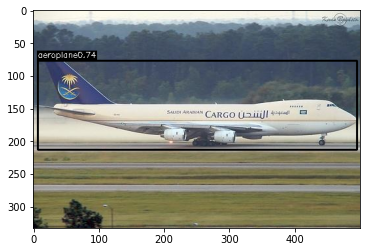

In [38]:
visualize(model, './misc/lab07/Generate_dataset/images/004199.jpg')

car0.82


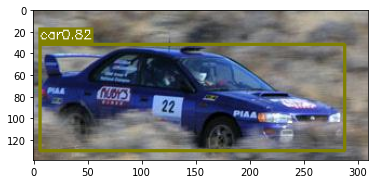

In [39]:
visualize(model, './misc/lab07/Generate_dataset/images/006034.jpg')

### Step 6-2. Inference (mAP)
- The below code is for checkout your network performance,
- By using this code, your network prediction is saved in Generate_dataset directory
- Then, %run ./misc/lab07/Generate_dataset/main.py
- After a few seconds, the mAP is printed.
- **Note that if your code is correct, the mAP will be over 69.**

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

SMALL_VOC_CLASSES = ('aeroplane', 'bicycle', 'bus', 'car', 'cat', 'dog')
os.makedirs('predicted', exist_ok=True)

def write(model, path):
    result = []
    image = cv2.imread(path)
    h, w, _ = image.shape
    img = cv2.resize(image, (448, 448))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    transform = transforms.Compose([transforms.ToTensor(),])
    img = 2 * transform(img) - 1
    img = Variable(img[None,:,:,:],volatile=True)
    img = img.cuda()
    
    pred = model(img) #1x7x7x30
    pred = pred.cpu()
    boxes,cls_indexs,probs =  interpret_target(pred, 0)
    
    
    txt_file = open(os.path.join('predicted', os.path.basename(path)[:-4]+'.txt'), 'w')
    
    for i, box in enumerate(boxes):
        
        x1 = max(int(box[0] * w), 0)
        x2 = min(int(box[2] * w), w)
        y1 = max(int(box[1] * h), 0)
        y2 = min(int(box[3] * h), h)
        cls_index = cls_indexs[i]
        cls_index = int(cls_index)
        prob = probs[i]
        prob = float(prob)
        txt_file.write(str(SMALL_VOC_CLASSES[cls_index])+' '+'%.6f'%(prob)+' '+str(x1)+' '+str(y1)+' '+str(x2)+' '+str(y2))
        txt_file.write('\n')
    txt_file.close()
    
import glob

model.eval()
img_names = glob.glob('./misc/lab07/Generate_dataset/images/*')

for i, file_name in enumerate(img_names):
    write(model, file_name)
    if i % 500 == 0:
        print(i)

0
500
1000


In [41]:
%run ./misc/lab07/Generate_dataset/main.py

68.78% = aeroplane AP 
67.03% = bicycle AP 
63.85% = bus AP 
70.24% = car AP 
73.60% = cat AP 
78.66% = dog AP 
mAP = 70.36%


<Figure size 432x288 with 0 Axes>

이번 실험에서는 YOLO를 구현했다. YOLO는 1 stage object detection 방식으로 구현된 모델로, Bounding box Coordination과 Classification을 동시에 진행한다는 특징이 있다. YOLO는 학습과 예측의 속도가 매우 빠르다는 점, 이미지 전체의 맥락을 학습하게 된다는 점, 대상의 일반적인 특징을 학습해 다른 영역으로의 확장이 뛰어나다는 점 등의 장점이 이싿. 

이번 실험과정에서 구현한 부분은 크게 논문의 모델 부분과 YOLO의 Loss부분이 있었다. 모델의 경우 이 Jupyter notebook에 제시되어 있는 YOLO 모델을 따라 구현하였다. 논문에서는 Activation functino으로 사용된 Leaky Relu의 negative slop가 0.1이었는데 제시된 조건에서는 negative slop가 0.01인 점 등 제시된 모델과 기존 모델간의 차이가 존재하였다.

YOLO loss의 경우 기존에 주어진 복잡한 형태의 방정식을 크게 5개 항으로 쪼개어 계산한 뒤 이를 더해주는 방식으로 구현하였다.
xy_loss, wh_loss, obj_loss, noobj_loss, prob_loss에 대해 각각 수식적인 계산을 진행한 뒤 최종적으로 loss식을
total_loss = (self.l_coord*(xy_loss + wh_loss) + obj_loss + self.l_noobj*(noobj_loss1 + noobj_loss2) + prob_loss)
와 같은 코드로 구현하였다. 이 과정에서 우리는 IoU라는 기준으로 Ground truth와 prediction을 비교하게 된다.
IoU는 간단하게 말하자면 미리 정해둔 답안 박스와 모델이 예측한 박스가 얼마나 많이 겹치느냐를 수치화 한 것이다.
다양하게 검출된 박스들 중 이 IoU가 일정 threshold를 넘는 박스를 찾아내면 적절한 Prediction결과를 낼 수 있게 된다.


Object detection의 성능을 측정하는 대표적인 방법 중 하나로 mAP 방식이 있다. Class가 여러 개인 경우 각 Class 당 AP(Average Precision)을 구하고 그것을 모두 합친 다음, 클래스의 개수로 나누어주면 mAP(mean Average Precision)을 구할 수 있다.
실험에서 구현한 모델을 학습시키고 mAP를 구해본 결과, 제시된 0.69보다 높은 0.704의 mAP를 얻을 수 있었고 모델이 올바르게 구현되었음을 확인할 수 있었다.

### *References*
[1] https://www.pyimagesearch.com/2018/05/14/a-gentle-guide-to-deep-learning-object-detection/

[2] https://github.com/Cartucho/mAP